In [1]:
from qubeui import Qube
from qubeui import display, QubeSetupPanel, QubeLoadConfigPanel

QUBE = Qube()
display(QubeLoadConfigPanel(QUBE))
display(QubeSetupPanel(QUBE))

QubeLoadConfigPanel(children=(HBox(children=(Text(value='qube_riken_1-01.yml', description='Config'), Button(d…

QubeSetupPanel(children=(Text(value='', description='IP Address for eXtickGE', disabled=True, style=Descriptio…

In [4]:
# QUBE.config['bitfile'] = '067d1e.bit'
# QUBE.config['ipfpga'] = '10.1.0.6'

In [33]:
import qubecalib as qc
import pickle

PORT_ID = 2
VATT = 0xC00
TYPE = 'A'

qube = QUBE.qube
port = qc.new_port_handler(qube)

if TYPE == 'A':
    qube.adrf6780[0].set_usb()
    qube.adrf6780[1].set_usb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_usb()
    qube.adrf6780[7].set_usb()
else:
    qube.adrf6780[0].set_lsb()
    qube.adrf6780[1].set_lsb()
    qube.adrf6780[2].set_lsb()
    qube.adrf6780[3].set_lsb()
    qube.adrf6780[4].set_lsb()
    qube.adrf6780[5].set_lsb()
    qube.adrf6780[6].set_lsb()
    qube.adrf6780[7].set_lsb()

# ms2038 = instruments.MS2038_SPA(visa)
# ms2038.write(':INIT:CONT OFF')

#fname = 'Qube{}_{}_Port{}_{}_coarse.pickle'.format(QUBE, QUBE_ID, PORT_ID, hex(VATT))
result = []

# Readout 9500 - 11000
#   IF 1300 - 2000
#   LO 8200 - 8500 

# try:
FL = 8200
FI = 1800
    # for FL in range(10400, 11001, 200): # for CTRL
    #     for FI in range(1800,3201,200): # for CTRL
    # # for FL in range(8200, 8501, 100): # for READOUT
    # #     for FI in range(1300,2001,100): # for READOUT
FR = FL - FI
qc.set_flo_fnco_according_to_frf(port[PORT_ID], FR, FI)
qc.set_vatt(port[PORT_ID].upconv.vatt, VATT)
# finally:
#     with open(fname, 'wb') as f:
#         pickle.dump(result, f)

2.4756043956043956

In [34]:
%matplotlib inline
import matplotlib.pylab as plt

import e7awg_sw.examples.send_recv.send_recv as sr
from e7awg_sw.examples.send_recv.send_recv import AWG, CaptureModule

sr.IP_ADDR = QUBE.config['ipfpga']

def save_sample_data(prefix, sampling_rate, id_to_samples):
    for id, samples in id_to_samples.items():
        # I/Q データテキストファイル保存
            for i_data, q_data in samples:
                print("{}  ,  {}\n".format(i_data, q_data))


def sendrecv(awgs, capture_modules, use_labrad, server_ip_addr):
    with (sr.create_awg_ctrl(use_labrad, server_ip_addr) as awg_ctrl,
          sr.create_capture_ctrl(use_labrad, server_ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*awgs)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        sr.set_trigger_awg(cap_ctrl, awgs[0], capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = sr.set_wave_sequence(awg_ctrl, awgs)
        # キャプチャパラメータの設定
        sr.set_capture_params(cap_ctrl, awg_to_wave_sequence[awgs[0]], capture_units)
        # 波形送信スタート
        awg_ctrl.start_awgs(*awgs)
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(5, *awgs)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)
        # エラーチェック
        sr.check_err(awg_ctrl, cap_ctrl, awgs, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = sr.get_capture_data(cap_ctrl, capture_units)
        # 波形保存
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
    return awg_to_wave_data, capture_unit_to_capture_data
        # save_sample_data('awg', sr.AwgCtrl.SAMPLING_RATE, awg_to_wave_data)
        # save_sample_data('capture', sr.CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data)
    # print('end')

awgs = AWG.all()
o = sendrecv(awgs, CaptureModule.all(), False, 'localhost')

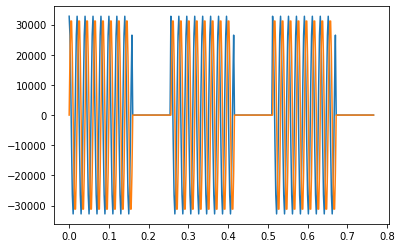

In [35]:
samples = o[0][0]
sampling_rate = sr.AwgCtrl.SAMPLING_RATE
time = np.linspace(0, 1000000 * len(samples) / sampling_rate, len(samples), endpoint=False)

iq = np.array(samples)

plt.plot(time, iq[:,0])
plt.plot(time, iq[:,1])

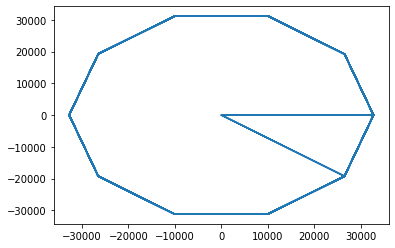

In [32]:
plt.plot(iq[:,0],iq[:,1])